In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit
from IPython.display import clear_output
from matplotlib import ticker

from notebooks.utils import *

In [2]:
from datetime import datetime, timezone
from zoneinfo import ZoneInfo

dt_local = datetime(2025, 9, 13, 21, 0, tzinfo=ZoneInfo("Europe/Zurich"))
dt_utc = dt_local.astimezone(timezone.utc)

runs, histories, config_df = load_runs(
    filters={
        # "tags": "crit_bs_l8_d512",
        "$and": [
            # {"$not": {"tags": "flagged"}},
            {"$or": [
                {"tags": "crit_bs_l8_d512"},
                {"tags": "crit_bs_l12_d768"},
                {"tags": "crit_bs_l16_d1024"},
                # {"tags": "scaling_laws"},
            ]},
            {"created_at": {"$gte": dt_utc.isoformat()}}
        ],
    },
    order="+created_at",
    drop_duplicates=["num_layers", "hidden_size", "learning_rate", "batch_size", "hybrid_mixing_shift"],
)

# config_df = config_df.sort_values(["total_steps", "final_elbo"], ascending=[False, True])#.drop_duplicates(subset=["num_layers", "hidden_size", "learning_rate", "batch_size", "hybrid_mixing_shift"])
len(config_df)

Processing runs:   0%|          | 0/460 [00:00<?, ?it/s]

Skipping run gidd-L8-D512-H8-N2048-bs=32-lr=0.3-noise_mask with insufficient steps: None
Skipping run gidd-L8-D512-H8-N2048-bs=256-lr=0.5-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_low_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_high_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_balanced with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_high_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=0.3-noise_balanced with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_uniform with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048-bs=256-lr=1.0-noise_mask with insufficient steps: None
Skipping run gidd-L16-D1024-H16-N2048

373

In [3]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [4]:
max_loss = 4.4
min_loss = float(min(h["train/elbo_ema"].min() for h in histories if "train/elbo_ema" in h))

loss_targets = np.logspace(np.log10(min_loss), np.log10(max_loss), 17)[::-1]
step_targets = [12500, 25000, 50000, 100000]

min_loss, max_loss

(2.7757811619381707, 4.4)

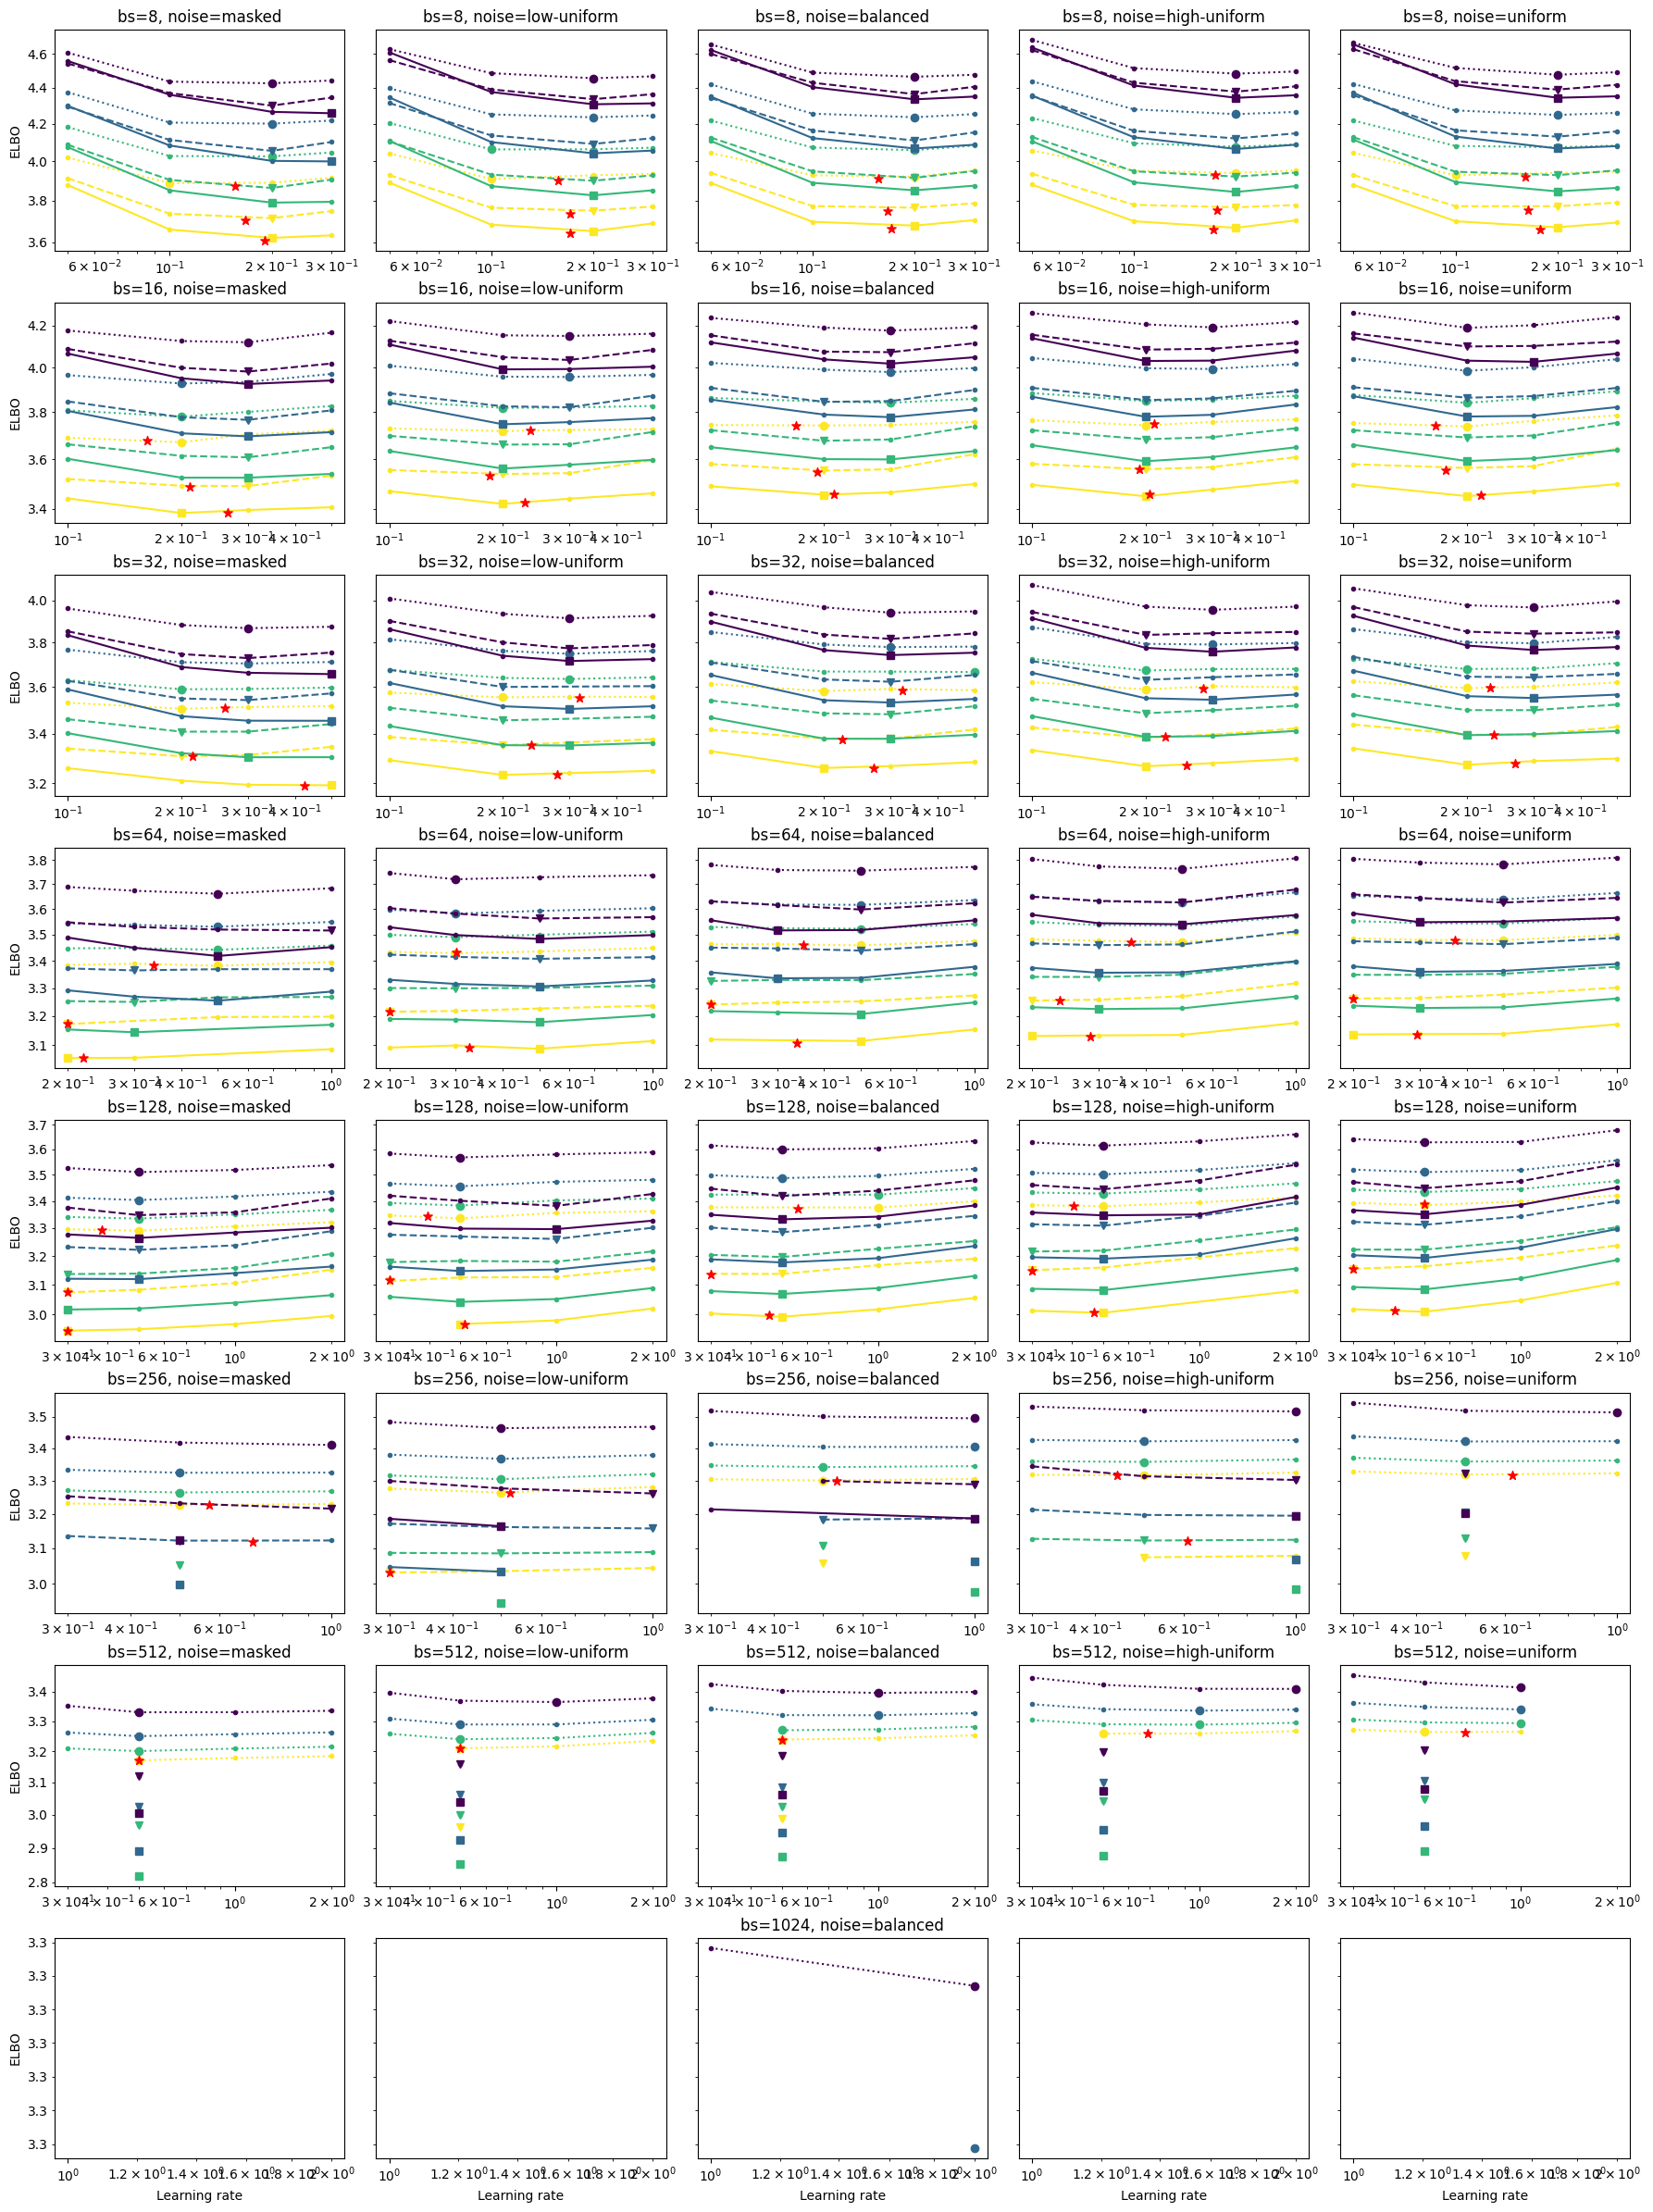

In [5]:
fig, axs = plt.subplots(8, 5, figsize=(18, 24), sharey="row", sharex="row")

def color(x, targets=step_targets, cmap=plt.get_cmap("viridis")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))


def quadratic(x, a, b, c):
    return b*(x - a)**2 + c

optimal_ids = []

linestyles = [":", "--", "-"]

shift_to_i = {
    -1000.0: 0,
    -2.0: 1,
    0.0: 2,
    2.0: 3,
    1000.0: 4,
}
batch_size_to_j = {
    8: 0,
    16: 1,
    32: 2,
    64: 3,
    128: 4,
    256: 5,
    512: 6,
    1024: 7,
}

xticks = sorted(set(config_df["lr"]))

markers = {
    0: "o",
    1: "v",
    2: "s",
}

opt_points = []

df_ = config_df[config_df["num_layers"].isin([8, 12, 16])]

# plt_idx = 0
for i, ((hybrid_mixing_shift, batch_size), dfi) in enumerate(df_.groupby(["hybrid_mixing_shift", "batch_size"])):
    # plt_idx += 1
    # ax = fig.add_subplot(5, 5, plt_idx)
    ax = axs[batch_size_to_j[batch_size], shift_to_i[float(hybrid_mixing_shift)]]
    for j, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
        dfj = dfj.sort_values("lr")

        opt_lr_fit, popt = None, None
        for k, steps in enumerate(step_targets):
            # lrs = dfj["lr"].values
            ids = [i for i in dfj.index if dfj.loc[i, "total_steps"] >= 0.99*steps]
            if len(ids) == 0:
                continue
            xs = np.array([dfj.loc[i, "lr"] for i in ids])
            ys = np.array([loss_at_t(steps, config_df.loc[i]) for i in ids])
            # ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in ids])
            # label = f"t={int(steps)/1000}k" if plt_idx == 1 and j == 2 else None
            label = None
            ax.plot(xs, ys, marker=".", linestyle=linestyles[j], label=label, color=color(steps))

            optimal_idx = np.argmin(ys)
            ax.plot(xs[optimal_idx], ys[optimal_idx], marker=markers.get(j), color=color(steps))
            # ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfj.index])

            if len(xs) >= 3:
                popt, _ = curve_fit(quadratic, np.log(xs), np.log(ys), p0=[xs[np.argmin(ys)], 1.0, min(ys)], maxfev=100000)
                if popt[1] < 0:
                    opt_lr_fit = xs[np.argmin(ys)]
                    # pass
                else:
                    opt_lr_fit = np.exp(popt[0]).clip(min(xs), max(xs))

            opt_points.append({
                "steps": steps,
                "batch_size": batch_size,
                "hybrid_mixing_shift": hybrid_mixing_shift,
                "num_layers": num_layers,
                "hidden_size": hidden_size,
                "opt_lr": xs[optimal_idx],
                "opt_lr_fit": opt_lr_fit,
                "opt_loss": ys[optimal_idx]
            })

        if opt_lr_fit is not None and popt is not None:
            ax.scatter(opt_lr_fit, np.exp(quadratic(np.log(opt_lr_fit), *popt)), marker="*", color="red", s=50, label=None, zorder=10)


    ax.set_title(f"bs={batch_size}, noise={get_noise_label(hybrid_mixing_shift)}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.set_xticks(xticks, [f"{x}" for x in xticks], minor=False)
    # ax.set_xticks([], [], minor=True)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:.1f}"))

for ax in axs[-1, :]:
    ax.set_xlabel("Learning rate")
for ax in axs[:, 0]:
    ax.set_ylabel("ELBO")
# if plt_idx == 1:
#     ax.legend(loc="upper left")

clear_output()

fig.tight_layout(h_pad=0.4, w_pad=0.05)
fig.savefig("plots/lr_bs_sweep.pdf", bbox_inches="tight")
fig.show()     

/tmp/ipykernel_1140321/3816452853.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_1140321/3816452853.py:53: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_1140321/3816452853.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_1140321/3816452853.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_1140321/3816452853.py:53: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_1140321/3816452853.py:63: OptimizeWarning: Co

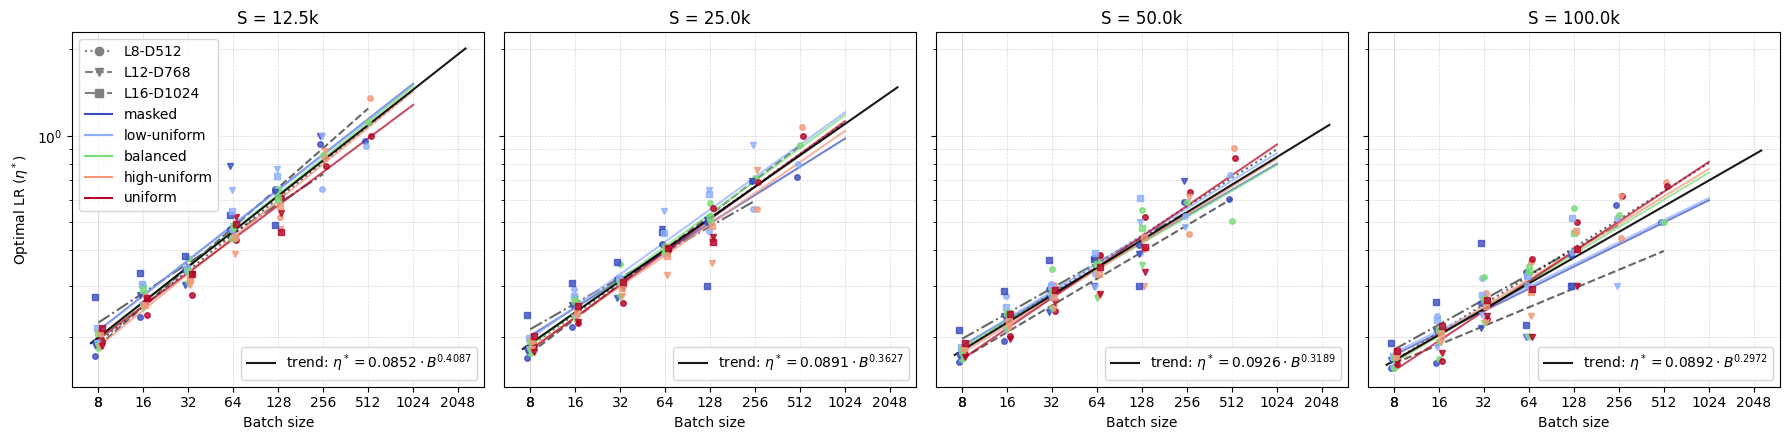

In [26]:
df_ = pd.DataFrame(opt_points).dropna()
# dfi = df_.loc[df_["steps"] >= 99000]

xticks = [8] + sorted(set(dfi["batch_size"])) + [1024, 2048]
yticks = sorted(set(dfi["opt_lr"]))

fig, axs = plt.subplots(1, 4, figsize=(18, 4.5), sharey=True, sharex=True)


def log_power_law(x, a, b, c):
    return a + x*b

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]

for idx, (steps, dfi) in enumerate(df_.groupby("steps")):
    ax = axs[idx]
    for i, ((num_layers), dfj) in enumerate(dfi.groupby("num_layers")):
        # points = []
        for j, (hybrid_mixing_shift, dfk) in enumerate(dfj.groupby("hybrid_mixing_shift")):
            dfk = dfk.sort_values("batch_size").dropna()
            xs = dfk["batch_size"].values*np.exp(0.05*(j-2)/2)
            ys = dfk["opt_lr_fit"].values
            # ys = dfk["target_loss"].values
            # xs = [dfk["opt_flop_fit"].values[i] / config_df.loc[ids[i], "non_emb_flops_per_token"] for i in range(len(ids))]
            # xs = ys / xs
            # points.extend(list(zip(xs, ys)))
            # points.extend([{"x": x, "y": y, "num_layers": num_layers, "hidden_size": hidden_size, "hybrid_mixing_shift": hybrid_mixing_shift} for x, y in zip(xs, ys)])
            ax.plot(xs, ys, marker=markers[i], color=color(hybrid_mixing_shift), linestyle="None", markersize=4, alpha=0.8, zorder=10)

    # dfi = pd.DataFrame(points)

    for i, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
        xs = dfj["batch_size"].values
        ys = dfj["opt_lr_fit"].values
        try:
            popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
            x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)*2), 100)
            y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
            ax.plot(x_fit, y_fit, linestyle=linestyles[i], color="black", alpha=0.6)
        except Exception as e:
            print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        label = get_noise_label(hybrid_mixing_shift)
        xs = dfj["batch_size"].values
        ys = dfj["opt_lr_fit"].values
        try:
            popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
            x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)*2), 100)
            y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
            ax.plot(x_fit, y_fit, linestyle="-", color=color(hybrid_mixing_shift), alpha=0.7)
        except Exception as e:
            print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

    try:
        xs = dfi["batch_size"].values
        ys = dfi["opt_lr_fit"].values
        popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
        x_fit = np.logspace(np.log10(8)-0.05, np.log10(2048)+0.05, 100)
        y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
        ax.plot(x_fit, y_fit, linestyle="solid", color="black", alpha=0.9, linewidth=1.5, label="trend: $\\eta^* = {:.3g}\\cdot B^{{{:.4g}}}$".format(np.exp(popt[0]), popt[1]))
    except Exception as e:
        print(f"Could not fit power law for all points: {e}")

    for i, (num_layers, hidden_size) in enumerate(dfi[["num_layers", "hidden_size"]].drop_duplicates().sort_values("num_layers").values):
        ax.plot([], [], label=f"L{num_layers}-D{hidden_size}", marker=markers[i], linestyle=linestyles[i], color="gray")

    for j, hybrid_mixing_shift in enumerate(sorted(dfi["hybrid_mixing_shift"].unique())):
        label = get_noise_label(hybrid_mixing_shift)
        ax.plot([], [], label=label, color=color(hybrid_mixing_shift))

    ax.set_title(f"S = {int(steps)/1000}k")

    ax.set_xscale("log")
    ax.set_yscale("log")

    if idx == 0:
        ax.set_ylabel("Optimal LR ($\\eta^*$)")
    # ax.set_ylabel("Target loss")
    ax.set_xlabel("Batch size")
    ax.set_xticks(xticks, [f"{x}" for x in xticks], minor=False)
    ax.set_xticks([], [], minor=True)
    # ax.set_yticks(yticks, [f"{y}" for y in yticks], minor=False)
    # ax.set_yticks([], [], minor=True)

    handles, labels = ax.get_legend_handles_labels()
    trend_mask = [lbl.startswith("trend:") for lbl in labels]
    trend_handles = [h for h, m in zip(handles, trend_mask) if m]
    trend_labels = [l for l, m in zip(labels, trend_mask) if m]
    main_handles = [h for h, m in zip(handles, trend_mask) if not m]
    main_labels = [l for l, m in zip(labels, trend_mask) if not m]

    if idx == 0:
        leg_main = ax.legend(main_handles, main_labels, loc="upper left")
        ax.add_artist(leg_main)
    ax.legend(trend_handles, trend_labels, loc="lower right")

    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
# ax.legend(loc="lower right")btw 
fig.tight_layout()
fig.savefig("plots/optimal_lr_vs_batch_size.pdf", bbox_inches="tight")


In [ ]:
# df_ = loss_df.loc[loss_df.groupby(["hybrid_mixing_shift", "num_layers", "target_loss"])["tokens"].idxmin()]

df_ = loss_df.loc[(loss_df["hybrid_mixing_shift"] == 0.0) & (loss_df["num_layers"] == 8)]

vmin = df_["target_loss"].min()
vmax = df_["target_loss"].max()

def color(val, cmap="viridis_r", vmin=vmin, vmax=vmax):
    ratio = (val - vmin) / (vmax - vmin)
    ratio = max(0.0, min(1.0, ratio))
    cmap = plt.get_cmap(cmap)
    return cmap(ratio)

# for _, dfi in df_.groupby("tokens"):
df_ = df_.sort_values("batch_size")
idx = df_.groupby(["batch_size", "tokens"])["target_loss"].idxmin()
ys = df_["batch_size"][idx]*2048
xs = df_["tokens"][idx] / ys

# print(target_loss)
# print(dfi.loc[idx]["name"])
# plt.plot(xs, ys, alpha=1.0, color=color(target_loss))

print(df_["lr"][idx])

plt.scatter(xs, ys, c=df_["lr"][idx], alpha=1.0, s=10, cmap="viridis_r")

xs = np.logspace(8, 11, 50)
ys = 10**-2.609 * xs**0.8368
# plt.plot(xs, ys, "--", label="B*Tokens^0.8368", color="red")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Tokens")
plt.ylabel("Batch Size")

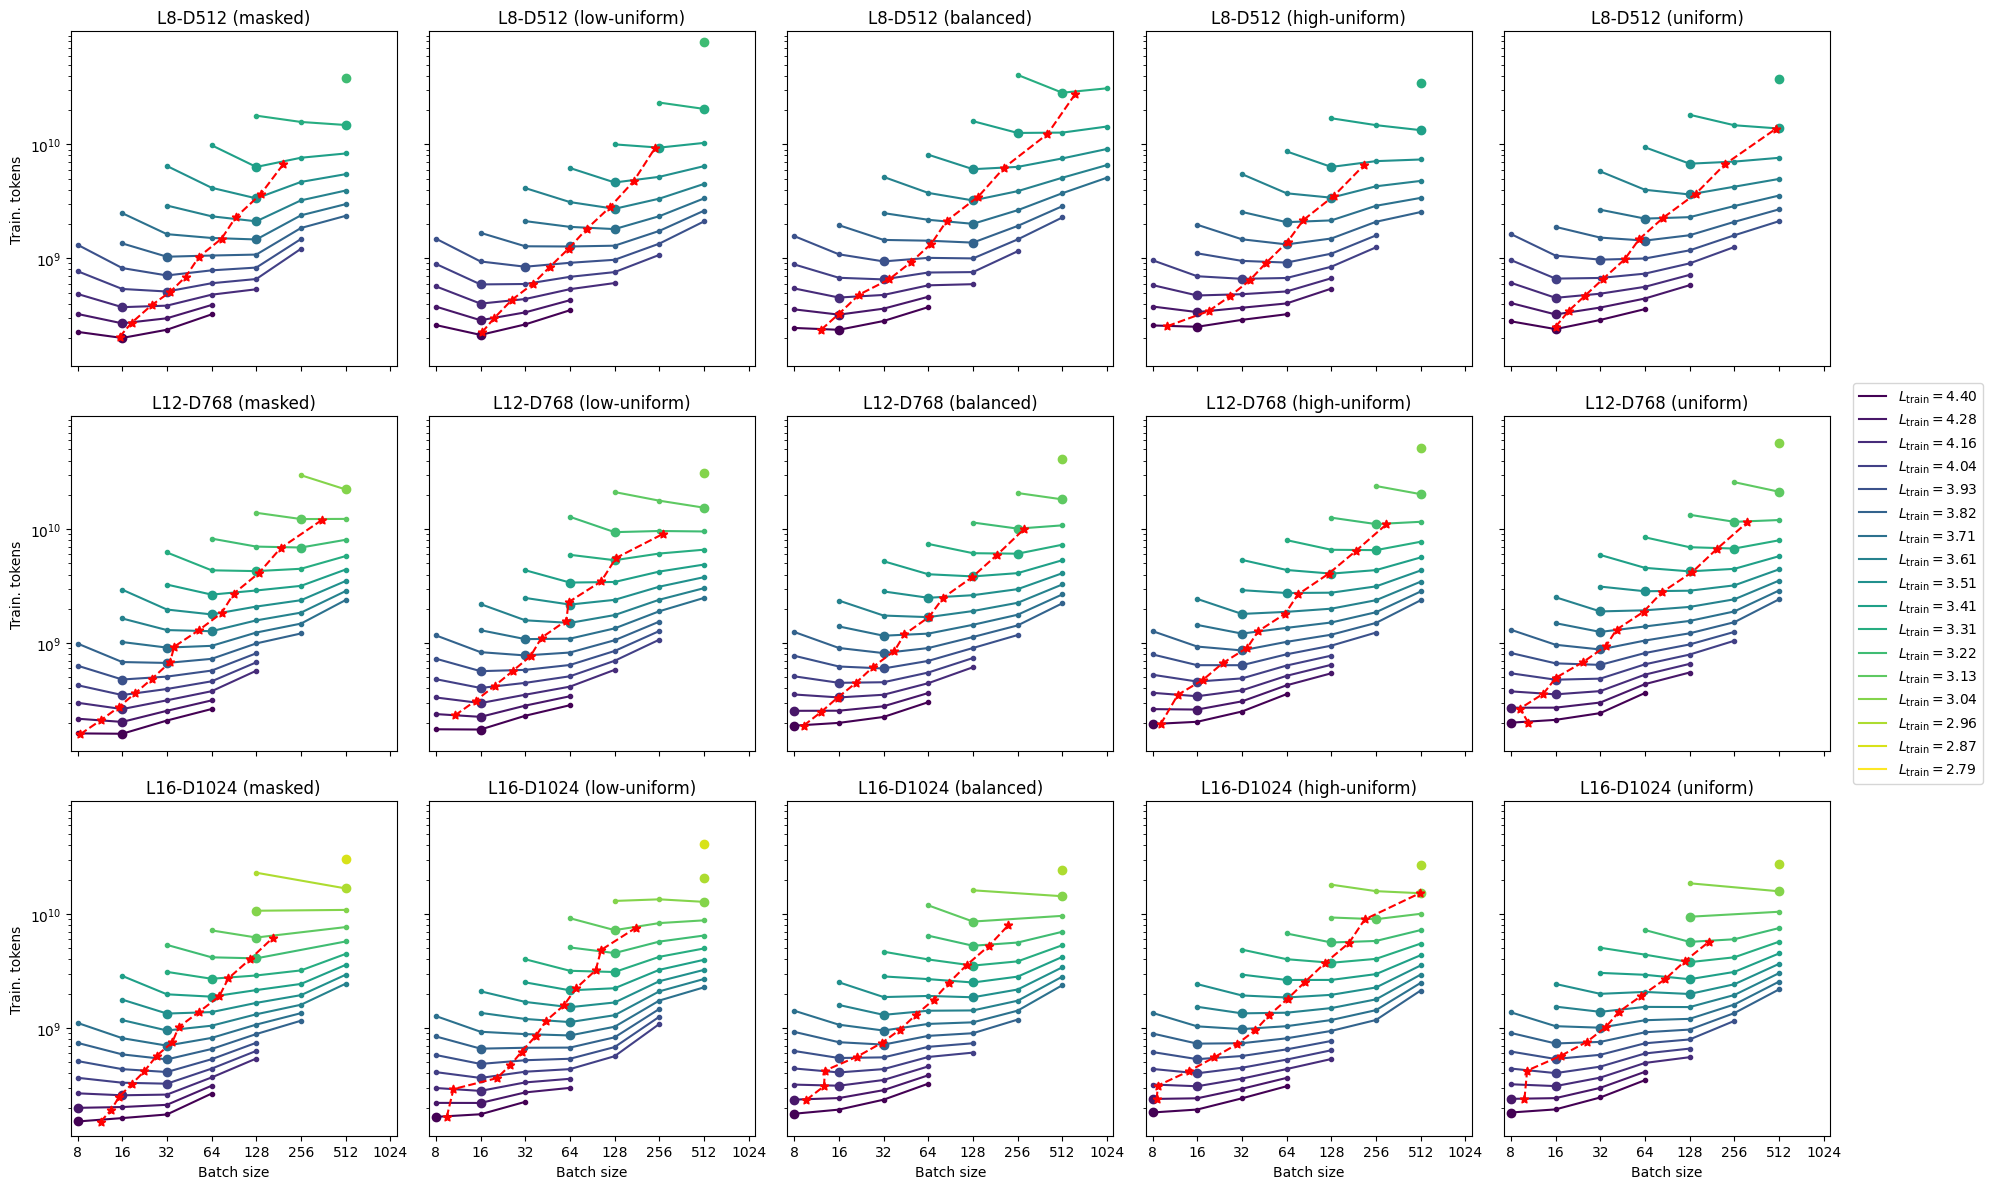

In [208]:
from collections import defaultdict

fig, axs = plt.subplots(3, 5, figsize=(20, 12), sharey="row", sharex=True)


def quadratic(x, a, b, c):
    return np.exp(a) * (x - b)**2 + c


def color(x, targets=loss_targets, cmap=plt.get_cmap("viridis_r")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))

optimal_ids = []

linestyles = [":", "--", "-"]

# df_ = config_df[config_df["num_layers"].isin([8, 12, 16])]
df_ = config_df.loc[config_df.groupby(["num_layers", "batch_size", "hybrid_mixing_shift"])["final_elbo"].idxmin()]

batch_sizes = sorted(df_["batch_size"].unique())

flop_optimal = []
all_points = []

plt_idx = 0
min_y = float("inf")
max_y = float("-inf")
# axs = []
for i, ((num_layers, hidden_size), dfi) in enumerate(df_.groupby(["num_layers", "hidden_size"])):
    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        plt_idx += 1
        # ax = fig.add_subplot(3, 5, plt_idx)
        # axs.append(ax)
        ax = axs[i, j]
        opt_batch_fits = []
        for k, target_loss in enumerate(loss_targets):
            dfj = dfj.sort_values("batch_size")
            predicted_steps = [steps_at_loss(target_loss, config_df.loc[i]) for i in dfj.index]
            ids = [dfj.index[i] for i, s in enumerate(predicted_steps) if s >= 2000 and s <= dfj.loc[dfj.index[i], "total_steps"]]
            if len(ids) == 0:
                continue

            xs = np.array([dfj.loc[i, "batch_size"] for i in ids])
            flops = np.array([flops_at_loss(target_loss, config_df.loc[i], include_emb_flops=False) for i in ids])
            tokens = np.array([tokens_at_loss(target_loss, config_df.loc[i]) for i in ids])
            ys = tokens
            ax.plot(xs, ys, marker=".", linestyle="-", color=color(target_loss))
            min_y = min(min_y, ys.min())
            max_y = max(max_y, ys.max())

            opt_batch_size_fit, opt_tokens_fit, opt_flop_fit = None, None, None
            if len(ys) >= 3:
                try:
                    popt, pcov = curve_fit(quadratic, np.log(xs), np.log(ys), maxfev=10000)
                    x_fit = np.logspace(np.log10(xs.min()), np.log10(xs.max()), 100)
                    y_fit = np.exp(quadratic(np.log(x_fit), *popt))
                    opt_fit_idx = np.argmin(y_fit)
                    if opt_fit_idx > 0 and opt_fit_idx < len(x_fit) - 1:
                        opt_batch_size_fit = x_fit[opt_fit_idx]
                        opt_tokens_fit = y_fit[opt_fit_idx]
                        opt_flop_fit = opt_tokens_fit * config_df.loc[ids[0], "non_emb_flops_per_token"]
                        ax.scatter([opt_batch_size_fit], [opt_tokens_fit], marker="*", color="red", alpha=1.0, zorder=10)
                        opt_batch_fits.append((opt_batch_size_fit, opt_tokens_fit))
                except Exception as e:
                    print(f"Could not fit for L{num_layers}-D{hidden_size} ({get_noise_label(hybrid_mixing_shift)}) at loss={target_loss}: {e}")

            optimal_idx = np.argmin(ys)
            opt_x = xs[optimal_idx]
            opt_y = ys[optimal_idx]
            ax.plot(opt_x, opt_y, marker="o", color=color(target_loss))
            opt_flops = flops[optimal_idx]
            opt_tokens = tokens[optimal_idx]

            flop_optimal.append({
                "optimal_idx": ids[optimal_idx],
                "params": dfj.loc[ids[optimal_idx], "params"],
                "non_emb_params": dfj.loc[ids[optimal_idx], "non_emb_params"],
                "num_layers": num_layers,
                "hidden_size": hidden_size,
                "hybrid_mixing_shift": hybrid_mixing_shift,
                "opt_batch_size": opt_x,
                "opt_flops": opt_flops,
                "opt_tokens": opt_tokens,
                "target_loss": target_loss,
                "opt_batch_size_fit": opt_batch_size_fit,
                "opt_flop_fit": opt_flop_fit,
                "opt_tokens_fit": opt_tokens_fit,
            })

            all_points.extend([{
                "batch_size": x,
                "tokens": toks,
                "flops": fl,
                "num_layers": num_layers,
                "hidden_size": hidden_size,
                "params": dfj.loc[ids[0], "params"],
                "non_emb_params": dfj.loc[ids[0], "non_emb_params"],
                "hybrid_mixing_shift": hybrid_mixing_shift,
                "target_loss": target_loss,
            } for x, toks, fl in zip(xs, tokens, flops)])

        xs, ys = zip(*opt_batch_fits) if len(opt_batch_fits) > 0 else ([], [])
        if len(xs) > 0:
            ax.plot(xs, ys, marker="*", linestyle="--", color="red", alpha=1.0)

        ax.set_title(f"L{num_layers}-D{hidden_size} ({get_noise_label(hybrid_mixing_shift)})")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks(batch_sizes, [f"{x}" for x in batch_sizes], minor=False)
        ax.set_xticks([], [], minor=True)
        # ax.set_ylabel("FLOPs")
        # ax.set_xlabel("Batch size")

for ax in axs[-1, :]:
    ax.set_xlabel("Batch size")
for ax in axs[:, 0]:
    ax.set_ylabel("Train. tokens")

for target_loss in loss_targets:
    label = f"$L_\\mathrm{{train}}={target_loss:.2f}$"
    axs.flat[9].plot([], [], label=label, color=color(target_loss))
axs.flat[9].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

for ax in axs.flat:
    ax.set_ylim(0.75*min_y, 1.25*max_y)
    ax.set_xlim(0.9*min(batch_sizes), 1.1*max(batch_sizes))

clear_output()

fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

fig.savefig("plots/critical_batch_size.pdf", bbox_inches="tight")
fig.show()     

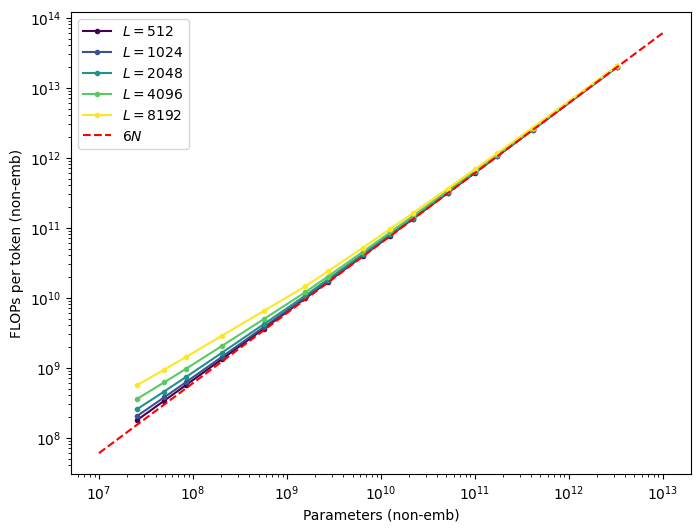

In [209]:
model_sizes = [
    (8, 8*64, 8),
    (10, 10*64, 10),
    (12, 12*64, 12),
    (16, 16*64, 16),
    (20, 12*128, 12),
    (20, 20*128, 20),
    (24, 24*128, 24),
    (32, 32*128, 32),
    (40, 40*128, 40),
    (48, 48*128, 48),
    (64, 64*128, 64),
    (80, 80*128, 80),
    (96, 96*128, 96),
    (128, 128*128, 128),
    (256, 256*128, 256),
]

fig, ax = plt.subplots(figsize=(8, 6))

seq_lens = [512, 1024, 2048, 4096, 8192]

def color(x, targets=seq_lens, cmap=plt.get_cmap("viridis")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))

for seq_len in seq_lens:
# for num_layers, hidden_size, num_heads in model_sizes:
    params = [params_from_config({"num_layers": num_layers, "hidden_size": hidden_size}, include_embed_params=False) for (num_layers, hidden_size, num_heads) in model_sizes]
    # flops_per_tok = flops_per_step(num_layers, hidden_size, num_heads, seq_length=seq_len, batch_size=1, include_embed_flops=False) / seq_len
    flops_per_tok = [flops_per_step(num_layers, hidden_size, num_heads, seq_length=seq_len, batch_size=1, include_embed_flops=False) / seq_len for (num_layers, hidden_size, num_heads) in model_sizes]
    ax.plot(params, flops_per_tok, marker="." if seq_len == 2048 else ".", label=f"$L={seq_len}$", color=color(seq_len))

xs = np.logspace(7, 13, 100)
ys = 6*xs
ax.plot(xs, ys, linestyle="--", color="red", label="$6 N$")

plt.xlabel("Parameters (non-emb)")
plt.ylabel("FLOPs per token (non-emb)")

plt.xscale("log")
plt.yscale("log")
plt.legend();

/tmp/ipykernel_702636/2566841592.py:37: OptimizeWarning:

Covariance of the parameters could not be estimated

/tmp/ipykernel_702636/2566841592.py:49: OptimizeWarning:

Covariance of the parameters could not be estimated

/tmp/ipykernel_702636/2566841592.py:59: OptimizeWarning:

Covariance of the parameters could not be estimated



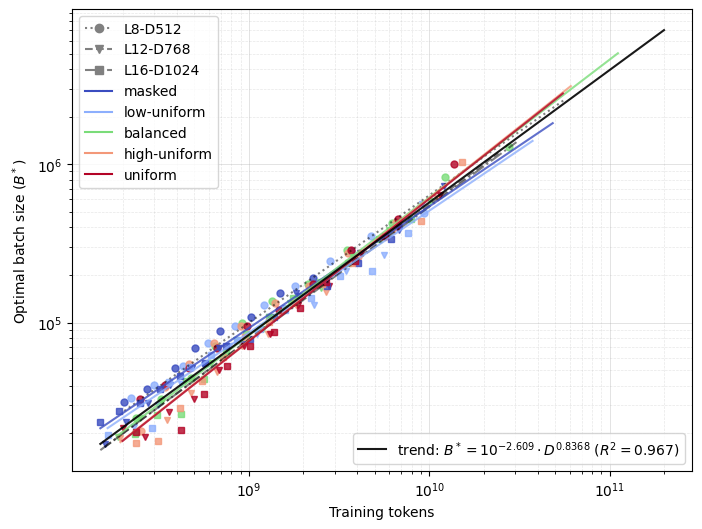

In [210]:
df_ = pd.DataFrame(flop_optimal)
df_ = df_.loc[df_["num_layers"].isin([8, 12, 16])]

fig, ax = plt.subplots(figsize=(8, 6))


def log_power_law(x, a, b, c):
    return a + x*b

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]
all_points = []
for i, ((num_layers, hidden_size), dfi) in enumerate(df_.groupby(["num_layers", "hidden_size"])):
    # points = []
    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        dfj = dfj.sort_values("opt_batch_size_fit").dropna()
        ids = dfj["optimal_idx"].values
        ys = dfj["opt_batch_size_fit"].values * 2048
        # ys = dfj["target_loss"].values
        xs = [dfj["opt_flop_fit"].values[i] / config_df.loc[ids[i], "non_emb_flops_per_token"] for i in range(len(ids))]
        # xs = ys / xs
        # points.extend(list(zip(xs, ys)))
        all_points.extend([{"x": x, "y": y, "num_layers": num_layers, "hidden_size": hidden_size, "hybrid_mixing_shift": hybrid_mixing_shift} for x, y in zip(xs, ys)])
        # ax.plot(xs, ys, marker=markers[i], linestyle=linestyles[i], color=color(hybrid_mixing_shift), linewidth=0.9, markersize=5, alpha=0.8)
        ax.plot(xs, ys, marker=markers[i], linestyle="none", color=color(hybrid_mixing_shift), linewidth=0.9, markersize=5, alpha=0.8)

dfi = pd.DataFrame(all_points)

for i, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
    xs = dfj["x"].values
    ys = dfj["y"].values
    try:
        popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
        x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)*2), 100)
        y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
        ax.plot(x_fit, y_fit, linestyle=linestyles[i], color="black", alpha=0.5)
    except Exception as e:
        print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
    label = get_noise_label(hybrid_mixing_shift)
    xs = dfj["x"].values
    ys = dfj["y"].values
    try:
        popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
        x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)*4), 100)
        y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
        ax.plot(x_fit, y_fit, linestyle="-", color=color(hybrid_mixing_shift), alpha=0.8)
    except Exception as e:
        print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

try:
    xs = dfi["x"].values
    ys = dfi["y"].values
    popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
    r2 = 1 - (np.sum((np.log(ys) - log_power_law(np.log(xs), *popt))**2) / np.sum((np.log(ys) - np.mean(np.log(ys)))**2))
    x_fit = np.logspace(np.log10(min(xs)), np.log10(2e11), 100)
    y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
    ax.plot(x_fit, y_fit, linestyle="solid", color="black", alpha=0.9, linewidth=1.5, label="trend: $B^* = 10^{{{:.4g}}} \\cdot D^{{{:.4g}}}$ ($R^2 = {:.3g}$)".format(popt[0] / np.log(10), popt[1], r2))
except Exception as e:
    print(f"Could not fit power law for all points: {e}")

for i, (num_layers, hidden_size) in enumerate(df_[["num_layers", "hidden_size"]].drop_duplicates().sort_values("num_layers").values):
    ax.plot([], [], label=f"L{num_layers}-D{hidden_size}", marker=markers[i], linestyle=linestyles[i], color="gray")

for j, hybrid_mixing_shift in enumerate(sorted(df_["hybrid_mixing_shift"].unique())):
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot([], [], label=label, color=color(hybrid_mixing_shift))

ax.set_ylabel("Optimal batch size ($B^*$)")
# ax.set_ylabel("Target loss")
ax.set_xlabel("Training tokens")


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("trend:") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper left")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower right")

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3)
fig.savefig("plots/critical_batch_size_vs_tokens.pdf", bbox_inches="tight")

/tmp/ipykernel_4057048/724464369.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)


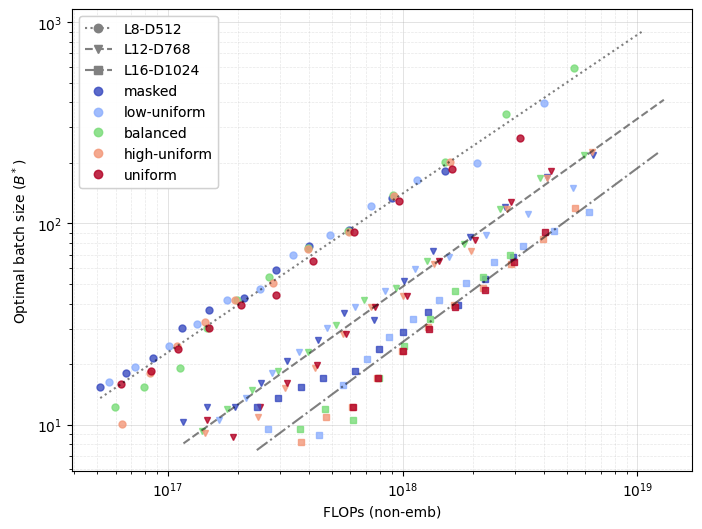

In [265]:
df_ = pd.DataFrame(flop_optimal)

fig, ax = plt.subplots(figsize=(8, 6))


def log_power_law(x, a, b, c):
    return a + x*b

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]
all_points = []
for i, ((num_layers, hidden_size), dfi) in enumerate(df_.groupby(["num_layers", "hidden_size"])):
    # points = []
    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        dfj = dfj.sort_values("opt_batch_size_fit").dropna()
        ids = dfj["optimal_idx"].values
        ys = dfj["opt_batch_size_fit"].values
        # ys = dfj["target_loss"].values
        xs = [dfj["opt_flop_fit"].values[i] for i in range(len(ids))]
        # xs = ys / xs
        # points.extend(list(zip(xs, ys)))
        all_points.extend([{"x": x, "y": y, "num_layers": num_layers, "hidden_size": hidden_size, "hybrid_mixing_shift": hybrid_mixing_shift} for x, y in zip(xs, ys)])
        ax.plot(xs, ys, marker=markers[i], linestyle="none", color=color(hybrid_mixing_shift), linewidth=0.9, markersize=5, alpha=0.8)

dfi = pd.DataFrame(all_points)

for i, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
    xs = dfj["x"].values
    ys = dfj["y"].values
    try:
        popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
        x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)*2), 100)
        y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
        ax.plot(x_fit, y_fit, linestyle=linestyles[i], color="black", alpha=0.5)
    except Exception as e:
        print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

# for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
#     label = get_noise_label(hybrid_mixing_shift)
#     xs = dfj["x"].values
#     ys = dfj["y"].values
#     try:
#         popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
#         x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)*4), 100)
#         y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
#         ax.plot(x_fit, y_fit, linestyle="-", color=color(hybrid_mixing_shift), alpha=0.8)
#     except Exception as e:
#         print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

# try:
#     xs = dfi["x"].values
#     ys = dfi["y"].values
#     popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
#     r2 = 1 - np.sum((np.log(ys) - log_power_law(np.log(xs), *popt))**2) / np.sum((np.log(ys) - np.log(np.mean(ys)))**2)
#     x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)), 100)
#     y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
#     ax.plot(x_fit, y_fit, linestyle="solid", color="black", alpha=0.9, linewidth=1.5, label="trend: $B^* = 10^{{{:.4g}}} \\cdot D^{{{:.4g}}}$ ($R^2 = {:.3g}$)".format(popt[0] / np.log(10), popt[1], r2))
# except Exception as e:
#     print(f"Could not fit power law for all points: {e}")

for i, (num_layers, hidden_size) in enumerate(df_[["num_layers", "hidden_size"]].drop_duplicates().sort_values("num_layers").values):
    ax.plot([], [], label=f"L{num_layers}-D{hidden_size}", marker=markers[i], linestyle=linestyles[i], color="gray")

for j, hybrid_mixing_shift in enumerate(sorted(df_["hybrid_mixing_shift"].unique())):
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot([], [], label=label, linestyle="none", marker="o", color=color(hybrid_mixing_shift), alpha=0.8)

ax.set_ylabel("Optimal batch size ($B^*$)")
# ax.set_ylabel("Target loss")
ax.set_xlabel("FLOPs (non-emb)")


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("trend:") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper left")
ax.add_artist(leg_main)
# ax.legend(trend_handles, trend_labels, loc="lower right")

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3)
fig.savefig("plots/critical_batch_size_vs_flops.pdf", bbox_inches="tight")

/tmp/ipykernel_4057048/1884128087.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_4057048/1884128087.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
/tmp/ipykernel_4057048/1884128087.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)


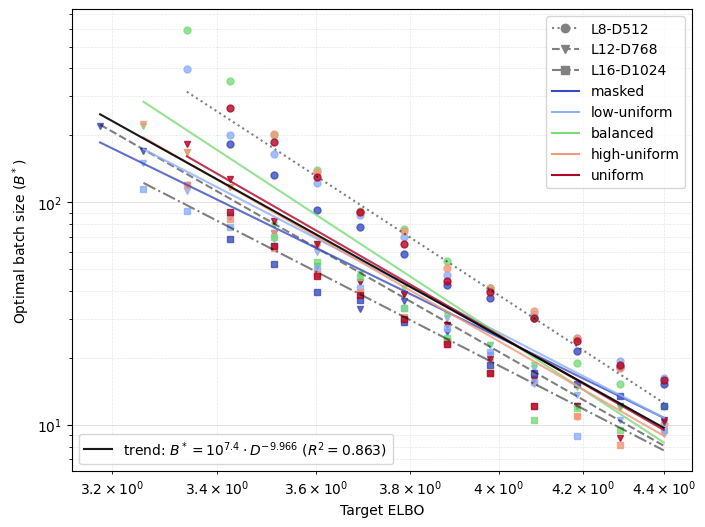

In [10]:
df_ = pd.DataFrame(flop_optimal)

fig, ax = plt.subplots(figsize=(8, 6))


def log_power_law(x, a, b, c):
    return a + x*-b

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

markers = ["o", "v", "s"]
linestyles = [":", "--", "-."]
all_points = []
for i, ((num_layers, hidden_size), dfi) in enumerate(df_.groupby(["num_layers", "hidden_size"])):
    # points = []
    for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
        dfj = dfj.sort_values("opt_batch_size_fit").dropna()
        ids = dfj["optimal_idx"].values
        ys = dfj["opt_batch_size_fit"].values
        xs = dfj["target_loss"].values
        # xs = [dfj["opt_flop_fit"].values[i] for i in range(len(ids))]
        # xs = ys / xs
        # points.extend(list(zip(xs, ys)))
        all_points.extend([{"x": x, "y": y, "num_layers": num_layers, "hidden_size": hidden_size, "hybrid_mixing_shift": hybrid_mixing_shift} for x, y in zip(xs, ys)])
        ax.plot(xs, ys, marker=markers[i], linestyle="none", color=color(hybrid_mixing_shift), linewidth=0.9, markersize=5, alpha=0.8)

dfi = pd.DataFrame(all_points)

for i, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
    xs = dfj["x"].values
    ys = dfj["y"].values
    try:
        popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
        x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)), 100)
        y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
        ax.plot(x_fit, y_fit, linestyle=linestyles[i], color="black", alpha=0.5)
    except Exception as e:
        print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

for j, (hybrid_mixing_shift, dfj) in enumerate(dfi.groupby("hybrid_mixing_shift")):
    label = get_noise_label(hybrid_mixing_shift)
    xs = dfj["x"].values
    ys = dfj["y"].values
    try:
        popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
        x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)), 100)
        y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
        ax.plot(x_fit, y_fit, linestyle="-", color=color(hybrid_mixing_shift), alpha=0.8)
    except Exception as e:
        print(f"Could not fit power law for L{num_layers}-D{hidden_size}: {e}")

try:
    xs = dfi["x"].values
    ys = dfi["y"].values
    popt, pcov = curve_fit(log_power_law, np.log(xs), np.log(ys), maxfev=10000)
    r2 = 1 - np.sum((np.log(ys) - log_power_law(np.log(xs), *popt))**2) / np.sum((np.log(ys) - np.log(np.mean(ys)))**2)
    x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)), 100)
    y_fit = np.exp(log_power_law(np.log(x_fit), *popt))
    ax.plot(x_fit, y_fit, linestyle="solid", color="black", alpha=0.9, linewidth=1.5, label="trend: $B^* = 10^{{{:.4g}}} \\cdot D^{{{:.4g}}}$ ($R^2 = {:.3g}$)".format(popt[0] / np.log(10), -popt[1], r2))
except Exception as e:
    print(f"Could not fit power law for all points: {e}")

for i, (num_layers, hidden_size) in enumerate(df_[["num_layers", "hidden_size"]].drop_duplicates().sort_values("num_layers").values):
    ax.plot([], [], label=f"L{num_layers}-D{hidden_size}", marker=markers[i], linestyle=linestyles[i], color="gray")

for j, hybrid_mixing_shift in enumerate(sorted(df_["hybrid_mixing_shift"].unique())):
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot([], [], label=label, color=color(hybrid_mixing_shift))

ax.set_ylabel("Optimal batch size ($B^*$)")
# ax.set_ylabel("Target loss")
ax.set_xlabel("Target ELBO")


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("trend:") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.3)
fig.savefig("plots/critical_batch_size_vs_loss.pdf", bbox_inches="tight")

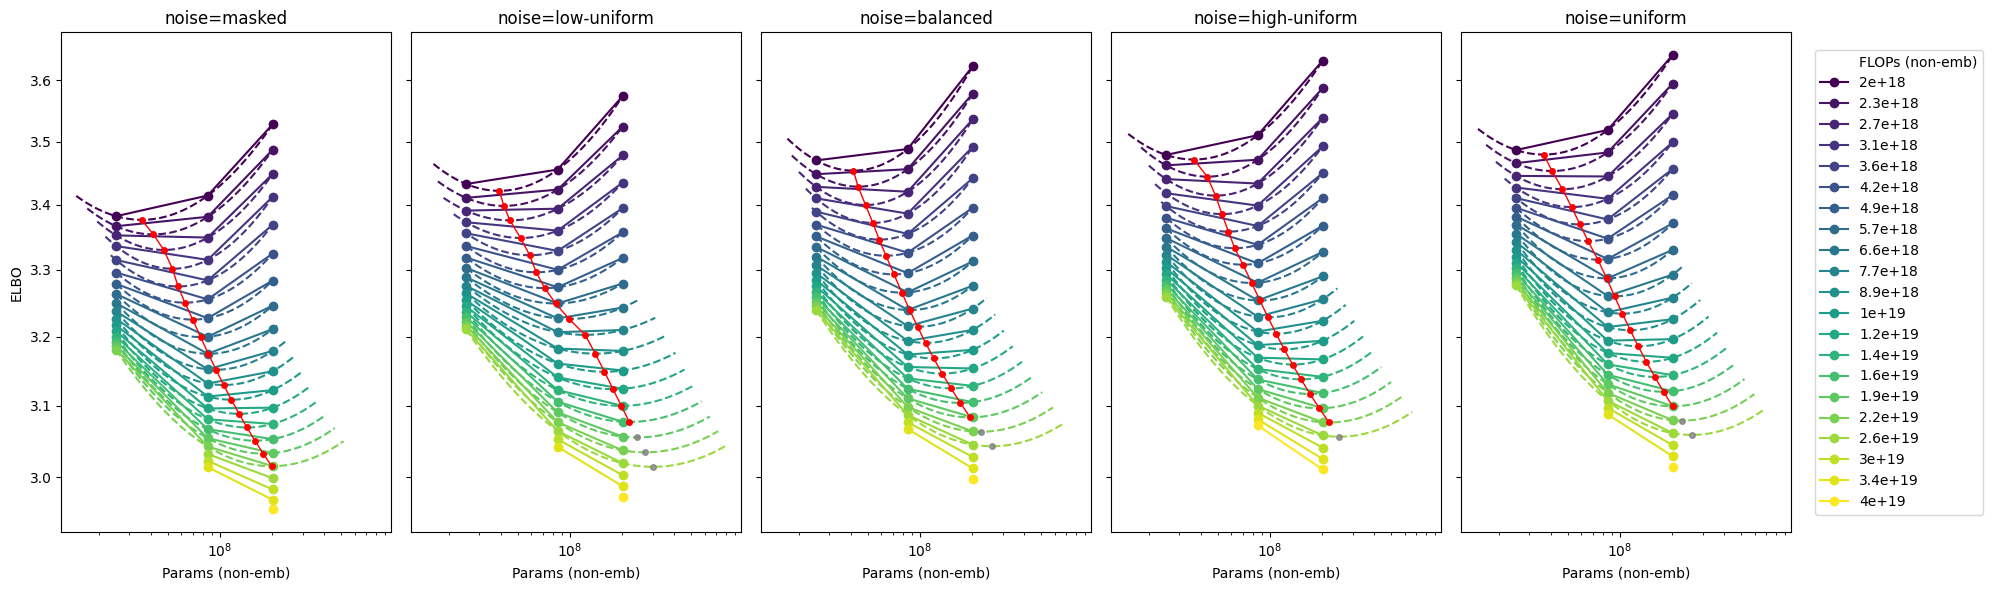

In [91]:
fig, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(20, 6))



df_ = config_df.loc[config_df.groupby(["num_layers", "hidden_size", "batch_size", "hybrid_mixing_shift"])["final_elbo"].idxmin()]


flop_targets = np.logspace(np.log10(2e18), np.log10(4e19), 21)

def color(x, targets=flop_targets, cmap=plt.get_cmap("viridis")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))


def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

plotted_targets = set()

# axs = []
all_opt_points = []
for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    # ax = fig.add_subplot(1, 5, i+1, sharey=axs[0] if len(axs) > 0 else None)
    # axs.append(ax)
    ax = axs[i]
    opt_points = []
    for target_flops in flop_targets:
        xs, ys = [], []
        for params, dfj in dfi.groupby("params"):
            # flops_per_step = dfj["flops_per_step"].values[0]
            steps = target_flops / dfj["non_emb_flops_per_step"]
            steps = steps[(steps >= 2000) & (steps <= 1.1*dfj["total_steps"])]
            if len(steps) == 0:
                continue
            # print(steps)
            # print(steps)
            losses = np.array([loss_at_t(steps.loc[i], config_df.loc[i]) for i in steps.index])
            losses = np.nan_to_num(losses, nan=np.inf)
            idx = steps.index[np.argmin(losses)]
            # idx = np.argmin(np.abs(dfj["opt_flops"] - target_flops))
            # Get the row corresponding to the closest FLOPs value
            # print(ys, idx)
            xs.append(config_df.loc[idx]["non_emb_params"])
            ys.append(np.min(losses))

            if len(ys) >= 3:
                # Fit a quadratic curve to the data points
                try:
                    popt, _ = curve_fit(quadratic, np.log(xs), np.log(ys))
                    opt_log_x = -popt[1] / (2 * popt[0])
                    opt_log_y = quadratic(opt_log_x, *popt)
                    log_x_fit = np.linspace(min(*np.log(xs), 0.95*opt_log_x), max(*np.log(xs), 1.05*opt_log_x), 100)
                    log_y_fit = quadratic(log_x_fit, *popt)
                    ax.plot(np.exp(log_x_fit), np.exp(log_y_fit), linestyle="--", color=color(target_flops), alpha=1.0)
                    opt_x = np.exp(opt_log_x)
                    opt_y = np.exp(opt_log_y)
                    if opt_x < 0.9*min(xs) or opt_x > 1.1*max(xs):
                        ax.plot(np.exp(opt_log_x), np.exp(opt_log_y), marker=".", color="gray", markersize=8, alpha=0.8, zorder=10)
                    else:
                        # ax.plot(np.exp(opt_log_x), np.exp(opt_log_y), marker=".", color="red", zorder=10)
                        opt_points.append({
                            "hybrid_mixing_shift": hybrid_mixing_shift,
                            "params": params,
                            "non_emb_params": config_df.loc[idx]["non_emb_params"],
                            "opt_params": np.exp(opt_log_x),
                            "opt_loss": np.exp(opt_log_y),
                            "opt_tokens": target_flops / (6*np.exp(opt_log_x)),
                            "target_flops": target_flops,
                        })
                except Exception as e:
                    print(f"Curve fitting failed: {e}")
                    pass
        
        if len(ys) > 0:
            ax.plot(xs, ys, marker="o", linestyle="-", label=None, color=color(target_flops))
            plotted_targets.add(target_flops)
        
    if len(opt_points) > 0:
        _df = pd.DataFrame(opt_points)
        ax.plot(_df["opt_params"], _df["opt_loss"], marker=".", color="red", markersize=8, linewidth=1.0, zorder=10)
    all_opt_points.extend(opt_points)

    ax.set_xscale("log")
    ax.set_yscale("log")
    # set major tick locators and labels
    import matplotlib.ticker as ticker
    from matplotlib.ticker import LogLocator
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0]))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    # ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    # ax.set_xticks(sorted(config_df["params"].unique()), [f"{x/1e6:.1f}M" for x in sorted(config_df["params"].unique())], minor=False)
    # ax.set_xticks([], [], minor=True)
    ax.set_xlabel("Params (non-emb)")
    ax.set_title(f"noise={get_noise_label(hybrid_mixing_shift)}")

axs[0].set_ylabel("ELBO")

axs[-1].plot([], [], marker="None", linestyle="None", label="FLOPs (non-emb)")
for flops in sorted(plotted_targets):
    axs[-1].plot([], [], marker="o", linestyle="-", label=f"{flops:.2g}", color=color(flops))
axs[-1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

clear_output()

fig.tight_layout()
fig.show()
fig.savefig("plots/optimal_model_size_fit.pdf", bbox_inches="tight")

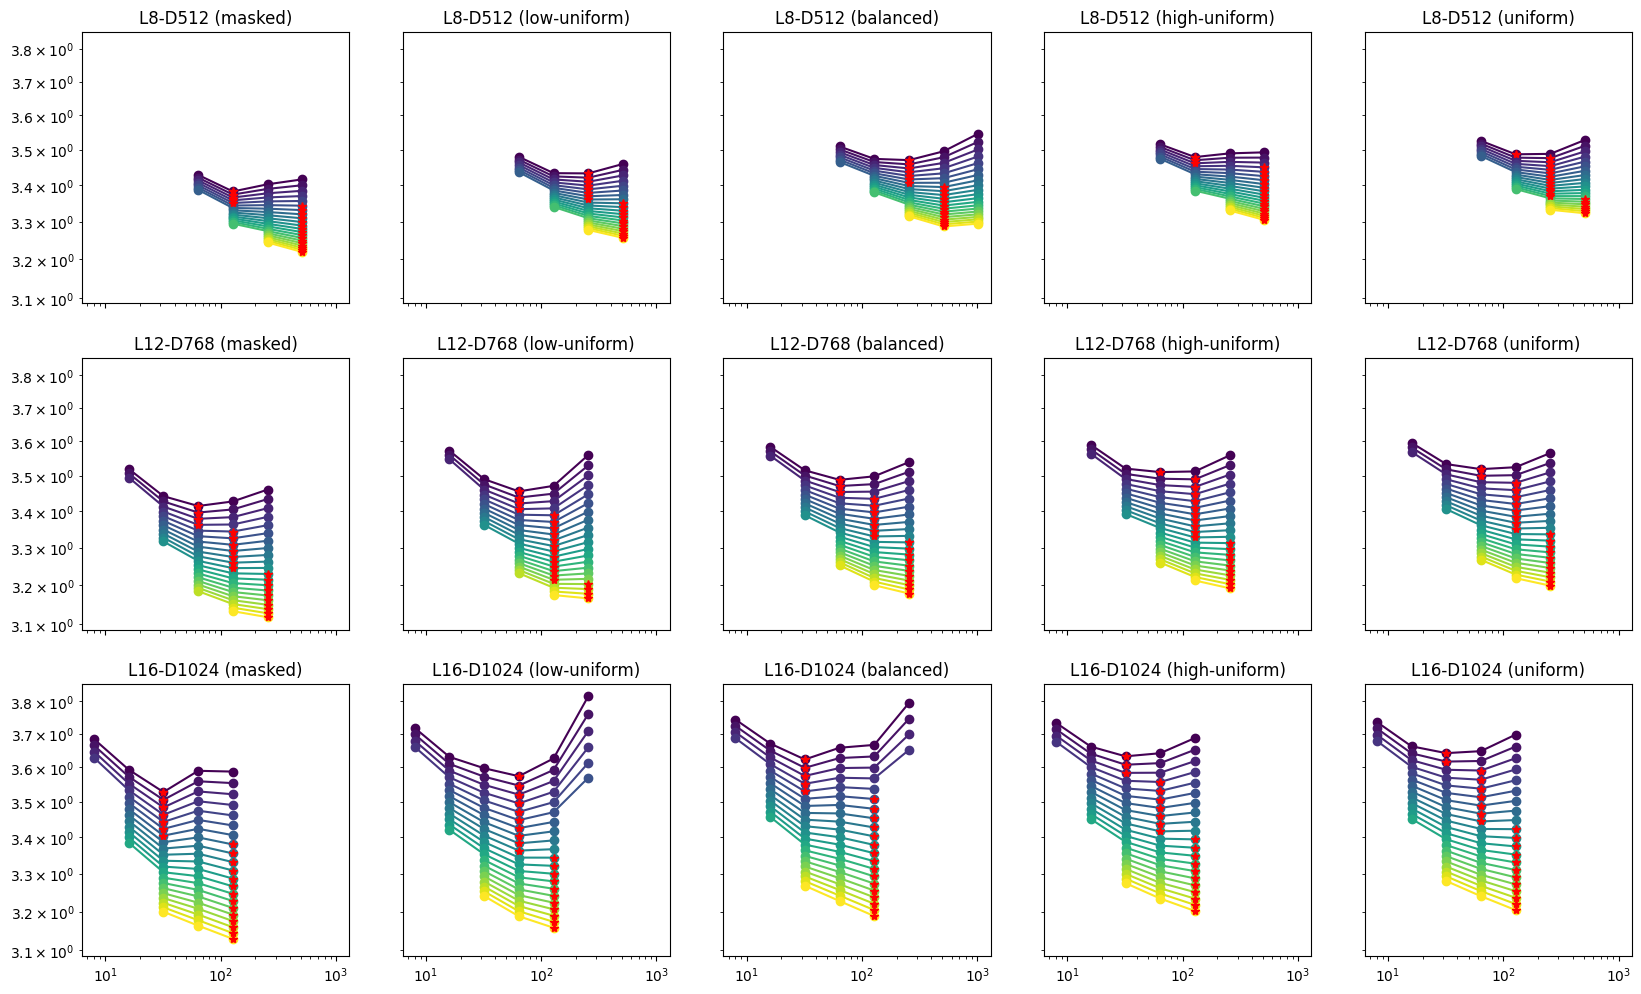

In [271]:
import importlib
import notebooks.utils
importlib.reload(notebooks.utils)
from notebooks.utils import loss_at_flops

fig, axs = plt.subplots(3, 5, sharey=True, sharex=True, figsize=(20, 12))
# fig = plt.figure(figsize=(20, 20))

df_ = config_df.loc[config_df.groupby(["num_layers", "hidden_size", "batch_size", "hybrid_mixing_shift"])["final_elbo"].idxmin()]


flop_targets = np.logspace(np.log10(2e18), np.log10(1e19), 21)

def color(x, targets=flop_targets, cmap=plt.get_cmap("viridis")):
    return cmap((np.log10(x) - np.log10(min(targets))) / (np.log10(max(targets)) - np.log10(min(targets))))


def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

plotted_targets = set()


opt_points = []
for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    for j, ((num_layers, hidden_size), dfj) in enumerate(dfi.groupby(["num_layers", "hidden_size"])):
        ax = axs[j, i]
        for target_flops in flop_targets:
            dfj = dfj.sort_values("batch_size")

            xs = dfj["batch_size"].values
            ys = np.array([loss_at_flops(target_flops, config_df.loc[idx], include_emb_flops=False) for idx in dfj.index])
            opt_i = np.argmin(np.nan_to_num(ys, nan=1e9))
            opt_x = xs[opt_i]
            opt_y = ys[opt_i]
            ax.plot(xs, ys, marker="o", linestyle="-", color=color(target_flops))
            ax.plot(opt_x, opt_y, marker="*", color="red", zorder=10)

            opt_points.append({
                "hybrid_mixing_shift": hybrid_mixing_shift,
                "num_layers": num_layers,
                "hidden_size": hidden_size,
                "params": dfj.loc[dfj.index[opt_i], "params"],
                "non_emb_params": dfj.loc[dfj.index[opt_i], "non_emb_params"],
                "opt_batch_size": opt_x,
                "opt_loss": opt_y,
                "target_flops": target_flops,
            })

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(f"L{num_layers}-D{hidden_size} ({get_noise_label(hybrid_mixing_shift)})")
        # ax.legend()


/tmp/ipykernel_4057048/3902108292.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(quadratic, np.log(xs), np.log(ys))


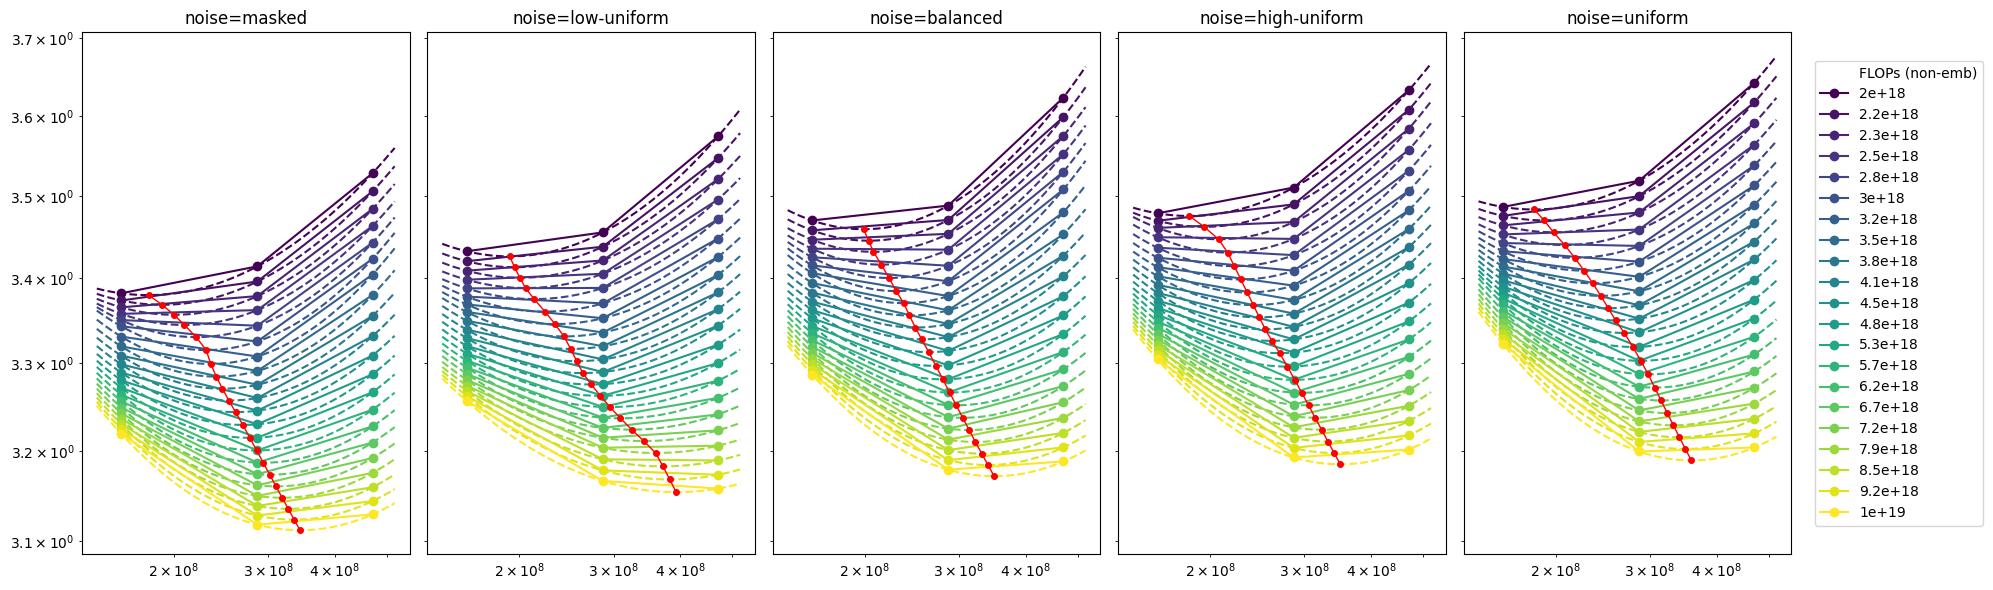

In [105]:
fig, axs = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(20, 6))

df_ = pd.DataFrame(opt_points)

all_scaling_points = []
plotted_targets = set()
for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    ax = axs[i]
    scaling_points = []
    for j, (target_flops, dfj) in enumerate(dfi.groupby("target_flops")):
        dfj = dfj.sort_values("params")

        xs = dfj["params"].values
        ys = dfj["opt_loss"].values

        if len(xs) > 0:
            ax.plot(xs, ys, marker="o", linestyle="-", color=color(target_flops))
            plotted_targets.add(target_flops)

        if len(ys) >= 3:
                # Fit a quadratic curve to the data points
                try:
                    popt, _ = curve_fit(quadratic, np.log(xs), np.log(ys))
                    opt_log_x = -popt[1] / (2 * popt[0])
                    opt_log_y = quadratic(opt_log_x, *popt)
                    log_x_fit = np.linspace(min(*np.log(0.9*xs), 0.99*opt_log_x), max(*np.log(1.1*xs), 1.01*opt_log_x), 100)
                    log_y_fit = quadratic(log_x_fit, *popt)
                    ax.plot(np.exp(log_x_fit), np.exp(log_y_fit), linestyle="--", color=color(target_flops), alpha=1.0)
                    opt_x = np.exp(opt_log_x)
                    opt_y = np.exp(opt_log_y)
                    if opt_x < 0.95*min(xs) or opt_x > 1.05*max(xs):
                        ax.plot(np.exp(opt_log_x), np.exp(opt_log_y), marker=".", color="gray", markersize=8, alpha=0.8, zorder=10)
                    else:
                        ax.plot(np.exp(opt_log_x), np.exp(opt_log_y), marker=".", color="red", zorder=10)
                        scaling_points.append({
                            "hybrid_mixing_shift": hybrid_mixing_shift,
                            "params": params,
                            "non_emb_params": config_df.loc[idx]["non_emb_params"],
                            "opt_params": np.exp(opt_log_x),
                            "opt_loss": np.exp(opt_log_y),
                            "opt_tokens": target_flops / (6*np.exp(opt_log_x)),
                            "target_flops": target_flops,
                        })
                except Exception as e:
                    print(f"Curve fitting failed: {e}")
                    pass

    if len(scaling_points) > 0:
        _df = pd.DataFrame(scaling_points)
        ax.plot(_df["opt_params"], _df["opt_loss"], marker=".", color="red", markersize=8, linewidth=1.0, zorder=10)
    all_scaling_points.extend(scaling_points)

    # xs = dfi["params"].values
    # ys = dfi["opt_loss"].values
    # ax.scatter(xs, ys)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"noise={get_noise_label(hybrid_mixing_shift)}")
    # ax.set_xlabel("Optimal batch size")
    # if i == 0:
    #     ax.set_ylabel("Optimal ELBO")
    # ax.legend()


axs[-1].plot([], [], marker="None", linestyle="None", label="FLOPs (non-emb)")
for flops in sorted(plotted_targets):
    axs[-1].plot([], [], marker="o", linestyle="-", label=f"{flops:.2g}", color=color(flops))
axs[-1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.show()

(array([3.54105826, 0.05444188, 0.        ]), np.float64(2.188470293997083))

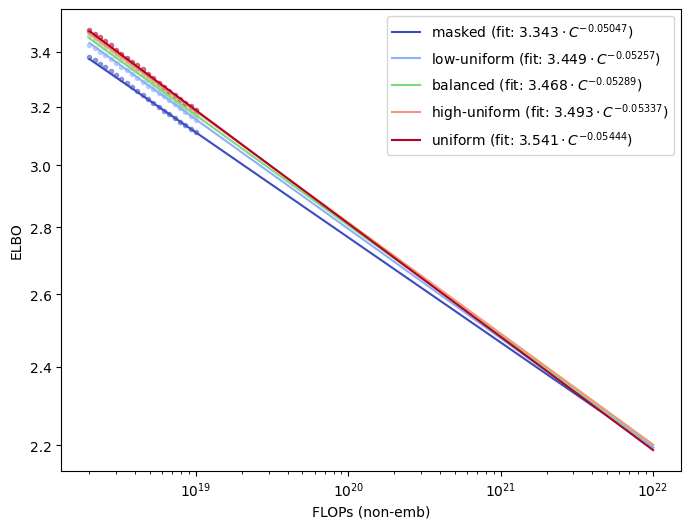

In [106]:
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator


df_ = pd.DataFrame(all_scaling_points).dropna()

def power_law(x, a, b, c):
    return np.exp(a) * x**-b #+ np.exp(c)

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

fig, ax = plt.subplots(figsize=(8, 6))

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    df_fit_ = dfi.loc[df_["target_flops"] >= 5e18]
    popt, _ = curve_fit(power_law, np.array(df_fit_["target_flops"]), np.array(df_fit_["opt_loss"]), maxfev=100000, p0=[3, 0.01, 0.0])

    plt.scatter(dfi["target_flops"], dfi["opt_loss"], color=color(hybrid_mixing_shift), marker=".", alpha=0.5)

    x_fit = np.logspace(np.log10(dfi["target_flops"].min()), np.log10(1e22), 100)
    y_fit = power_law(x_fit, *popt)
    ax.plot(x_fit, y_fit, color=color(hybrid_mixing_shift), label=f"{get_noise_label(hybrid_mixing_shift)} (fit: ${popt[0]:.4g}\cdot C^{{-{popt[1]:.4g}}}$)")

    # target_params = np.array([1.2e9, 6.4e9])
    # ax.scatter(target_params, power_law(target_params, *popt), marker="*", color="red", s=100, zorder=10)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("FLOPs (non-emb)")
ax.set_ylabel("ELBO")
ax.legend()
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0]))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

clear_output()

fig.savefig("plots/compute_optimal_loss_vs_flops.pdf", bbox_inches="tight")
popt, y_fit[-1]

(array([4.35739668, 0.16234116, 0.        ]), np.float64(1.857726209563892))

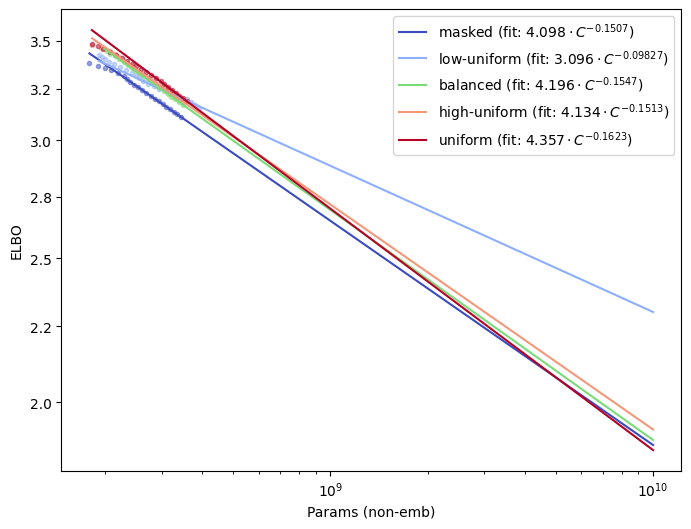

In [107]:
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator

def power_law(x, a, b, c):
    return np.exp(a) * x**-b #+ np.exp(c)

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

fig, ax = plt.subplots(figsize=(8, 6))

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    df_fit_ = dfi.loc[df_["target_flops"] >= 5e18]
    popt, _ = curve_fit(power_law, np.array(df_fit_["opt_params"]), np.array(df_fit_["opt_loss"]), maxfev=10000, p0=[3, 0.5, 0.0])

    plt.scatter(dfi["opt_params"], dfi["opt_loss"], marker=".", color=color(hybrid_mixing_shift), alpha=0.5)

    x_fit = np.logspace(np.log10(dfi["opt_params"].min()), np.log10(1e10), 100)
    y_fit = power_law(x_fit, *popt)
    # ax.plot(x_fit, y_fit, color=color(hybrid_mixing_shift), label=get_noise_label(hybrid_mixing_shift))
    ax.plot(x_fit, y_fit, color=color(hybrid_mixing_shift), label=f"{get_noise_label(hybrid_mixing_shift)} (fit: ${popt[0]:.4g}\cdot C^{{-{popt[1]:.4g}}}$)")

    # target_params = np.array([1.2e9, 6.4e9])
    # ax.scatter(target_params, power_law(target_params, *popt), marker="*", color="red", s=100, zorder=10)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Params (non-emb)")
ax.set_ylabel("ELBO")
ax.legend()
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0]))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

clear_output()

fig.savefig("plots/compute_optimal_loss_vs_params.pdf", bbox_inches="tight")

popt, y_fit[-1]

(array([1.76131045e-07, 3.01034519e+00, 0.00000000e+00]),
 np.float64(2.288932479323497e+26))

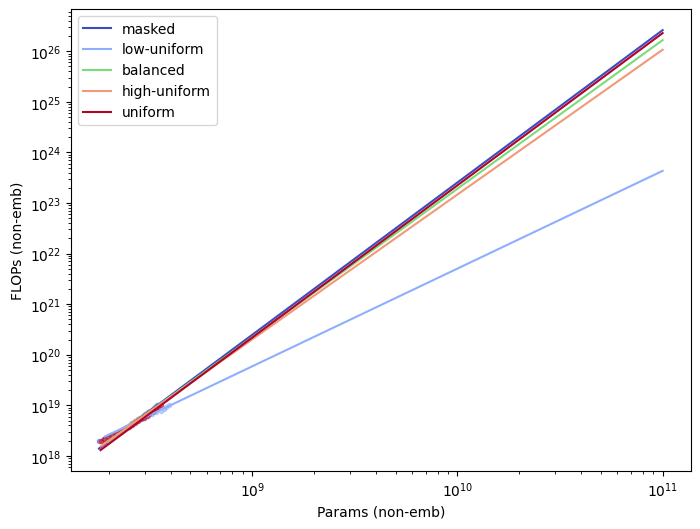

In [108]:
import matplotlib.ticker as ticker

def power_law(x, a, b, c):
    return a * x**b #+ np.exp(c)

def color(x):
    c = colors.get(float(x), (0, 0, 0))
    return tuple(v/255 for v in c)

fig, ax = plt.subplots(figsize=(8, 6))

for i, (hybrid_mixing_shift, dfi) in enumerate(df_.groupby("hybrid_mixing_shift")):
    df_fit_ = dfi.loc[df_["target_flops"] >= 5e18]
    popt, _ = curve_fit(power_law, np.array(df_fit_["opt_params"]), np.array(df_fit_["target_flops"]), maxfev=10000, p0=[1e15, 0.5, 0.0])

    plt.scatter(dfi["opt_params"], dfi["target_flops"], marker=".", color=color(hybrid_mixing_shift), alpha=0.5)

    x_fit = np.logspace(np.log10(dfi["opt_params"].min()), np.log10(1e11), 100)
    y_fit = power_law(x_fit, *popt)
    ax.plot(x_fit, y_fit, color=color(hybrid_mixing_shift), label=get_noise_label(hybrid_mixing_shift))

    # target_params = np.array([1.2e9, 6.4e9])
    # ax.scatter(target_params, power_law(target_params, *popt), marker="*", color="red", s=100, zorder=10)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Params (non-emb)")
ax.set_ylabel("FLOPs (non-emb)")
ax.legend()
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0], numticks=100))
# ax.yaxis.set_major_locator(ticker.LinearLocator(11))
# ax.yaxis.set_minor_locator(ticker.NullLocator())
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

clear_output()

fig.savefig("plots/compute_optimal_flops_vs_params.pdf", bbox_inches="tight")

popt, y_fit[-1]

/tmp/ipykernel_4057048/951436190.py:2: RuntimeWarning: overflow encountered in power
  return a * x**-b
/tmp/ipykernel_4057048/951436190.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(power_law, np.array(df_fit_["target_flops"]), np.array(df_fit_["opt_loss"]), maxfev=10000, p0=(1e3, 0.5, 1.0))


(array([32.06261371,  0.05289026,  1.        ]), np.float64(2.199952049454628))

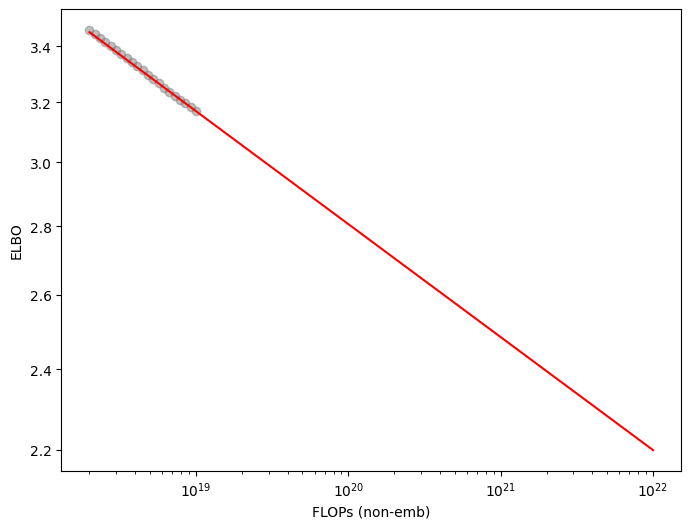

In [109]:
def power_law(x, a, b, c):
    return a * x**-b

dfi = df_.loc[df_["hybrid_mixing_shift"] == 0.0]

df_fit_ = dfi.loc[dfi["target_flops"] >= 5e18]
popt, _ = curve_fit(power_law, np.array(df_fit_["target_flops"]), np.array(df_fit_["opt_loss"]), maxfev=10000, p0=(1e3, 0.5, 1.0))

fig, ax = plt.subplots(figsize=(8, 6))


plt.scatter(dfi["target_flops"], dfi["opt_loss"], color="gray", alpha=0.5)
x_fit = np.logspace(np.log10(dfi["target_flops"].min()), np.log10(1e22), 100)
y_fit = power_law(x_fit, *popt)
ax.plot(x_fit, y_fit, color="red")

# target_params = np.array([1.2e9, 6.4e9])
# for tp in target_params:
#     ax.scatter([tp], [power_law(tp, *popt)], marker="*", color="blue", s=100, zorder=10)


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("FLOPs (non-emb)")
ax.set_ylabel("ELBO")
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0]))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

popt, y_fit[-1]

L24-D2048 - 1.2B params, 40.1B tokens, 3.4e+20 FLOPs
L32-D4096 - 6.4B params, 944.1B tokens, 4e+22 FLOPs
L40-D5120 - 12.6B params, 3293.3B tokens, 2.7e+23 FLOPs
L48-D6144 - 21.7B params, 9120.7B tokens, 1.3e+24 FLOPs


/tmp/ipykernel_4057048/2675614191.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(power_law, np.array(dfi["opt_params"]), np.array(dfi["target_flops"]), maxfev=10000, p0=[1e16, 1.0, 1e16])


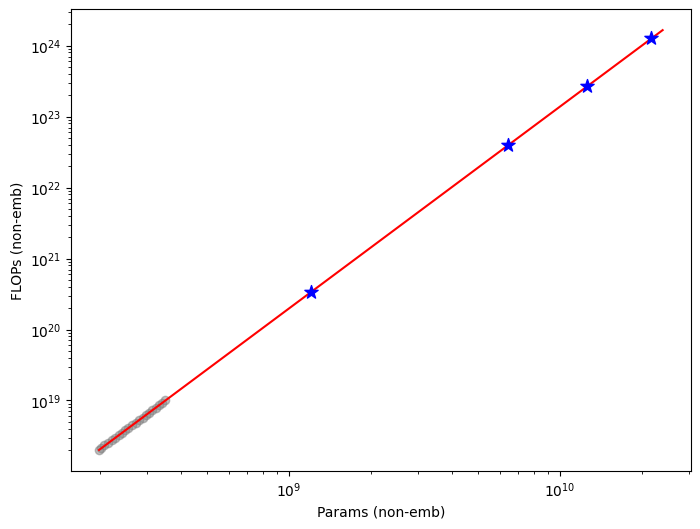

In [111]:
from notebooks.utils import params_from_config, flops_per_token

target_sizes = [
    {"num_layers": 24, "hidden_size": 16*128},
    {"num_layers": 32, "hidden_size": 32*128},
    {"num_layers": 40, "hidden_size": 40*128},
    {"num_layers": 48, "hidden_size": 48*128},
    # {"num_layers": 64, "hidden_size": 64*128},
]
target_params = np.array([params_from_config(cfg, include_embed_params=False) for cfg in target_sizes])

def power_law(x, a, b, c):
    return a * x**b

dfi = df_.loc[df_["hybrid_mixing_shift"] == 0.0]


df_fit_ = dfi.loc[dfi["target_flops"] >= 5e18]
popt, _ = curve_fit(power_law, np.array(dfi["opt_params"]), np.array(dfi["target_flops"]), maxfev=10000, p0=[1e16, 1.0, 1e16])

fig, ax = plt.subplots(figsize=(8, 6))

plt.scatter(dfi["opt_params"], dfi["target_flops"], color="gray", alpha=0.5)
x_fit = np.logspace(np.log10(dfi["opt_params"].min()), np.log10(target_params.max()*1.1), 100)
y_fit = power_law(x_fit, *popt)
ax.plot(x_fit, y_fit, color="red")

target_flops = power_law(target_params, *popt)
ax.scatter(target_params, target_flops, marker="*", color="blue", s=100, zorder=10)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Params (non-emb)")
ax.set_ylabel("FLOPs (non-emb)")

for cfg, params, flops in zip(target_sizes, target_params, target_flops):
    num_layers = cfg["num_layers"]
    hidden_size = cfg["hidden_size"]
    num_heads = hidden_size // 128
    num_tokens = flops / flops_per_token(num_layers, hidden_size, num_heads, 2048, include_embed_flops=False)
    print(f"L{num_layers}-D{hidden_size} - {params/1e9:.1f}B params, {num_tokens/1e9:.1f}B tokens, {flops:.2g} FLOPs")

# popt, target_flops